In [1]:
## import some modules between which also our hammer_fit

import numpy as np
import pyhf
import matplotlib.pyplot as plt
import json
from redist import modifier
from redist import modifier_hammer

In [2]:
# you can define your fitter in a json file and it will contain all the informations about:
#   - WCs to pass to Hammer
#   - FF parametrization in use
#   - the location of the file containing the hammer histograms

reader = modifier_hammer.Reader("./B02DstTauNu_config.json")

# createFitter produces a fitter object able handle the hammer histograms and produce the templates
fitter = reader.createFitter()

In [3]:
# definition of the alternative model (the nul model is stored in the fitter object)
SM_dist = fitter.nul_pdf()

def NP_dist(**kwargs):
    params_NP = {"SM" : kwargs["SM"], "Re_S_qLlL" : kwargs["Re_S_qLlL"], "Im_S_qLlL" : kwargs["Im_S_qLlL"], "Re_S_qRlL" : kwargs["Re_S_qRlL"], "Im_S_qRlL" : kwargs["Im_S_qRlL"],  "Re_V_qLlL" : kwargs["Re_V_qLlL"], "Im_V_qLlL" : kwargs["Im_V_qLlL"], "Re_V_qRlL" : kwargs["Re_V_qRlL"], "Im_V_qRlL" : kwargs["Im_V_qRlL"], "Re_T_qLlL" : kwargs["Re_T_qLlL"], "Im_T_qLlL" : kwargs["Im_T_qLlL"],"delta_RhoSq" : kwargs["FFs[8]"], "delta_cSt" : kwargs["FFs[0]"], "delta_chi21" : kwargs["FFs[6]"], "delta_chi2p" : kwargs["FFs[2]"], "delta_chi3p" : kwargs["FFs[9]"], "delta_eta1" : kwargs["FFs[7]"], "delta_etap" : kwargs["FFs[3]"], "delta_phi1p" : kwargs["FFs[1]"], "delta_beta21" : kwargs["FFs[5]"], "delta_beta3p" : kwargs["FFs[4]"],"lumi" : 1.}
    res = np.zeros(fitter._template_list[0]._nobs)
    for temp in fitter._template_list:
        res += temp.generate_template(**params_NP)
    return res

In [4]:
# loading of the model created in B02DstTauNu_model.ipynb
model, cmod, alt_yields = modifier_hammer.load_hammer('B02DstTauNu_model.json', NP_dist, SM_dist, return_modifier=True, return_data=True)
fitter.upload_data(alt_yields)
data = alt_yields + model.config.auxdata

In [5]:
# defining the starting values of the d.o.f.
init = model.config.suggested_init()
init[0] = 1. #SM
init[1] = 0. #ReSLL
init[2] = 0. #ImSLL
init[3] = 0. #ReSRL
init[4] = 0. #ImSRL
init[5] = 0. #ReVLL
init[6] = 0. #ImVLL
init[7] = 0. #ReVRL
init[8] = 0. #ImVRL
init[9] = 0. #ReTLL
init[10] = 0. #ImTLL

init[11] = 0. #FF1
init[12] = 0. #FF2
init[13] = 0. #FF3
init[14] = 0. #FF4
init[15] = 0. #FF5
init[16] = 0. #FF6
init[17] = 0. #FF7
init[18] = 0. #FF8
init[19] = 0. #FF9
init[20] = 0. #FF10

init[21] = 1. #mu nominal

In [6]:
# fixing the values of some of the d.o.f. (here we want to fit the Tensor WC)
fixed = model.config.suggested_fixed()
#fixed[0] = True #SM
fixed[1] = True #ReSLL
fixed[2] = True #ImSLL
fixed[3] = True #ReSRL
fixed[4] = True #ImSRL
fixed[5] = True #ReVLL
fixed[6] = True #ImVLL
fixed[7] = True #ReVRL
fixed[8] = True #ImVRL
#fixed[9] = True #ReTLL
#fixed[10] = True #ImTLL

#fixed[11] = True #FF1
#fixed[12] = True #FF2
#fixed[13] = True #FF3
#fixed[14] = True #FF4
#fixed[15] = True #FF5
#fixed[16] = True #FF6
#fixed[17] = True #FF7
#fixed[18] = True #FF8
#fixed[19] = True #FF9
#fixed[20] = True #FF10
fixed[21] = True # nomi mu

In [7]:
# pyhf fit and print of the best values

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed, init_pars=init)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=1))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
for i in range(len(best_fit)):
    print(f"{model.main_model.modifiers_appliers['custom'].param_viewer.allpar_viewer.names[i]} = {best_fit[i][0]} +/- {best_fit[i][1]}")

/home/mcolonna/.conda/envs/env_2024_11_25/lib/python3.10/site-packages/redist/modifier_hammer.py:61: RuntimeWarning: invalid value encountered in divide
  weights = np.array(alt_binned) / np.array(self.null_binned)


SM = 0.9941342108159253 +/- 0.0034035831993323717
Re_S_qLlL = 0.0 +/- 0.0
Im_S_qLlL = 0.0 +/- 0.0
Re_S_qRlL = 0.0 +/- 0.0
Im_S_qRlL = 0.0 +/- 0.0
Re_V_qLlL = 0.0 +/- 0.0
Im_V_qLlL = 0.0 +/- 0.0
Re_V_qRlL = 0.0 +/- 0.0
Im_V_qRlL = 0.0 +/- 0.0
Re_T_qLlL = -0.0021013947861852917 +/- 0.003689904024941841
Im_T_qLlL = -0.012467574352807204 +/- 0.026093824469569926
FFs_decorrelated[0] = 0.05790659045399048 +/- 0.9747485045352096
FFs_decorrelated[1] = -0.06721480748454725 +/- 0.9877585354814257
FFs_decorrelated[2] = 0.2584691909692416 +/- 0.9225458296462379
FFs_decorrelated[3] = 0.13552912570682166 +/- 0.9729991872708643
FFs_decorrelated[4] = -0.0019937820567027154 +/- 0.9827168193230789
FFs_decorrelated[5] = 0.0786874038530398 +/- 0.9877249023264693
FFs_decorrelated[6] = 0.4616727492392896 +/- 0.7989854521209498
FFs_decorrelated[7] = 0.2208809689410666 +/- 0.9397243541587302
FFs_decorrelated[8] = -0.1588690682929846 +/- 0.6288307409504711
FFs_decorrelated[9] = -0.0020053123312807125 +/- 0.946

/home/mcolonna/.conda/envs/env_2024_11_25/lib/python3.10/site-packages/redist/modifier_hammer.py:651: RuntimeWarning: invalid value encountered in divide
  ratio = contributions[0][i] / total_contribution
/home/mcolonna/.conda/envs/env_2024_11_25/lib/python3.10/site-packages/redist/modifier_hammer.py:652: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt(contributions[0][i]) / total_contribution


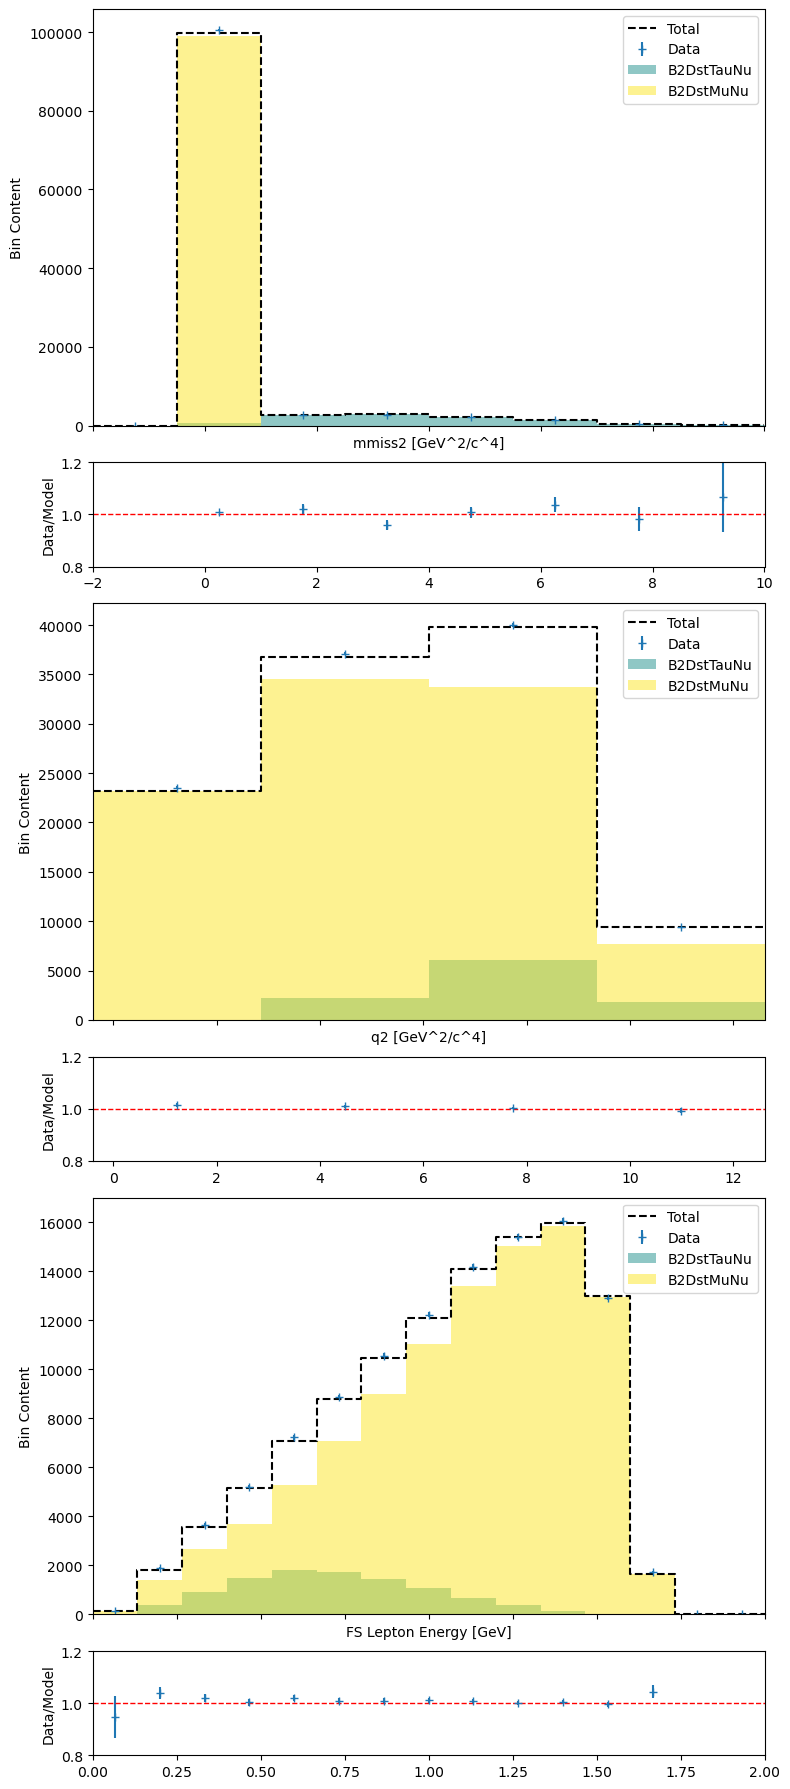

In [8]:
# plot the results from the fit (projections in the 3 axis) with the Hammer interface
params_toy = {"SM" : 1., "Re_S_qLlL" : 0., "Im_S_qLlL" : 0., "Re_S_qRlL" : 0., "Im_S_qRlL" : 0.,  "Re_V_qLlL" : 0., "Im_V_qLlL" : 0. , "Re_V_qRlL" : 0., "Im_V_qRlL" : 0., "Re_T_qLlL" : 0., "Im_T_qLlL" : 0., "delta_RhoSq" : 0., "delta_cSt" : 0., "delta_chi21" : 0., "delta_chi2p" : 0., "delta_chi3p" : 0., "delta_eta1" : 0., "delta_etap" : 0., "delta_phi1p" : 0., "delta_beta21" : 0., "delta_beta3p" : 0.,"lumi" : 1.}
best_fit_rot = cmod[0].rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
params = dict(zip(params_toy.keys(),best_fit_rot.values()))
fitter.plot(**params)